<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/associative_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dynamical Associative Memory for Real-Valued Pattern Recall

## 1. Introduction

Associative memory systems enable content-addressable retrieval of stored patterns. Instead of relying on explicit indices or addresses, these systems use a similarity-based mechanism to retrieve the most relevant memory based on input proximity. Classical implementations, such as the Hopfield network, use discrete-time binary dynamics with energy minimization. In contrast, the model presented here uses continuous-time dynamics governed by ordinary differential equations (ODEs), enabling the recall of real-valued vector patterns through smooth, differentiable flows in latent space.

This model constructs a dynamical system in which stored patterns act as attractors. Perturbed inputs evolve over time under the influence of a soft attention field, converging toward the nearest attractor. The approach achieves denoising and recall, using only a continuous ODE system and similarity-driven vector fields.


## 2. Background Concepts

### 2.1 Associative Memory Systems

An associative memory system stores a set of prototype vectors ${\mathbf{p}_1, \mathbf{p}_2, \dots, \mathbf{p}_N}$ and retrieves the most similar pattern given an input vector $\mathbf{x}_0$. The memory must possess:

* **Content-based recall**: Inputs resembling stored patterns trigger convergence to the correct memory.
* **Convergence dynamics**: The system evolves toward fixed points (attractors).
* **Noise tolerance**: The recall succeeds despite corrupted or partial inputs.

### 2.2 Dynamical Systems and Attractors

A continuous-time dynamical system evolves according to:

$$
\frac{d\mathbf{x}}{dt} = \mathbf{f}(\mathbf{x})
$$

Here, $\mathbf{x}(t) \in \mathbb{R}^d$ represents the system state, and $\mathbf{f}$ defines a velocity field. If the field directs trajectories toward specific points, those points act as **attractors**. The model constructs such a field using a soft attention mechanism to interpolate influence from the stored patterns.

### 2.3 Soft Attention via Distance Kernels

To influence the state $\mathbf{x}(t)$ based on similarity to patterns, the model defines softmax-based weights:

$$
w_i(\mathbf{x}) = \frac{ \exp\left( -\frac{ \| \mathbf{x} - \mathbf{p}_i \|^2 }{2\sigma^2} \right) }{ \sum_{j=1}^N \exp\left( -\frac{ \| \mathbf{x} - \mathbf{p}_j \|^2 }{2\sigma^2} \right) }
$$

These weights smoothly interpolate influence from all prototypes $\mathbf{p}_i$, depending on their distance to $\mathbf{x}$. The scale parameter $\sigma$ controls the sharpness of attention: small $\sigma$ yields focused attraction to nearby patterns, while large $\sigma$ distributes influence broadly.

## 3. Model Architecture

### 3.1 Memory Definition

Let $\mathcal{P} = \{\mathbf{p}_1, \dots, \mathbf{p}_N\} \subset \mathbb{R}^d$ represent the stored prototypes. Given a query vector $\mathbf{x}(t) \in \mathbb{R}^d$, the model defines its dynamics as:

$$
\frac{d\mathbf{x}}{dt} = \sum_{i=1}^N w_i(\mathbf{x}) \left( \mathbf{p}_i - \mathbf{x} \right)
$$

Each term $\left( \mathbf{p}_i - \mathbf{x} \right)$ acts as a vector pointing toward pattern $\mathbf{p}_i$, and the weight $w_i(\mathbf{x})$ determines its contribution. The update rule results in a smooth weighted average of all attraction vectors, forming a continuous vector field over $\mathbb{R}^d$. This field drives the system toward one of the prototypes, depending on the initial condition.

### 3.2 Dynamical Behavior

The system behaves as a **continuous attractor network**. Initial states closer to a particular pattern experience stronger pull toward that pattern, enabling robust recall. The trajectories are smooth, differentiable, and responsive to input perturbations, allowing integration into gradient-based frameworks if desired.

## 4. Training and Evaluation Procedure

### 4.1 Data Processing

The model uses MNIST digit images, focusing on a subset of classes (e.g., digits 0–3). Each image is:

1. Flattened and normalized to $[0,1]$.
2. Transformed via Principal Component Analysis (PCA) to $d$ dimensions.
3. Stored in the prototype memory $\mathcal{P}$.

### 4.2 Perturbation and Recall

Each test sample $\mathbf{x}_0$ undergoes Gaussian corruption:

$$
\mathbf{x}_\text{perturbed} = \mathbf{x}_0 + \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \sigma_\text{noise}^2 I)
$$

To recover the original pattern, the model simulates:

$$
\frac{d\mathbf{x}}{dt} = \sum_{i=1}^N w_i(\mathbf{x}) (\mathbf{p}_i - \mathbf{x})
$$

using a numerical ODE solver until reaching a maximum time $t_\text{max}$. The final state $\mathbf{x}(t_\text{max})$ serves as the recalled pattern. The model reconstructs images by applying the inverse PCA transformation.

## 5. Information-Theoretic Analysis

### 5.1 Entropy and Information Gain

To quantify recall performance, the model computes **information gain** using Shannon entropy. For a given class distribution $P(y)$:

$$
H(y) = -\sum_{c} P(c) \log_2 P(c)
$$

The model measures entropy before and after recall, then defines information gain as:

$$
\text{Information Gain} = H(\text{input labels}) - H(\text{output predictions})
$$

This metric evaluates how much uncertainty the recall process removes. High gain indicates successful convergence toward the correct class.

### 5.2 Empirical Findings

Information gain varies across digit classes. In observed experiments, the digit “1” demonstrated the highest gain, reflecting its structural simplicity and low intra-class variability. More complex digits like “3” showed lower gain, likely due to higher overlap with other classes in the PCA-reduced space.

## 6. Visualization and Results

Visual inspection of original, perturbed, and recalled samples confirms the system’s denoising capability. Noisy inputs often exhibit severe distortion, but the ODE dynamics restore clean, class-representative forms. The model successfully maps perturbed points back to meaningful attractors.

## 7. Implications and Extensions

The model provides a biologically plausible, continuous, and differentiable mechanism for associative recall. It does not require learning weights or training epochs. Instead, it leverages a static memory and continuous dynamics to achieve robust pattern recovery.

Possible extensions include:

* **Learnable memory updates** using ODEs inspired by Hebbian plasticity.
* **Clustering** to reduce prototype redundancy and improve memory capacity.
* **Adaptive kernels** that modify $\sigma$ based on local density.
* **Energy function derivation** to prove convergence and attractor stability.

## 8. Conclusion

This ODE-based associative memory system implements content-addressable recall for real-valued patterns using continuous-time dynamics. Each stored pattern exerts a soft, distance-weighted pull on the system's current state, enabling noisy inputs to converge to clean prototypes. The model achieves noise-robust recall and class-specific entropy reduction without relying on neural networks, learning algorithms, or discrete updates. As a foundational component, this system illustrates the potential of continuous dynamical fields in memory modeling and biologically inspired computation.


In [6]:
import numpy as np
from scipy.integrate import ode

# Define a distance metric
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

# Stored patterns in R^2
patterns = np.array([
    [1.0, 1.0],
    [-1.0, -1.0],
    [1.0, -1.0],
    [-1.0, 1.0]
])

sigma = 0.5

# Softmax weights
def weights(x):
    dists = np.array([np.linalg.norm(x - p)**2 for p in patterns])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

# ODE dynamics
def memory_dynamics(t, x):
    x = np.array(x)
    w = weights(x)
    dxdt = sum(w[i] * (patterns[i] - x) for i in range(len(patterns)))
    return dxdt

# Perturb a pattern
true_pattern_index = 0
true_pattern = patterns[true_pattern_index]
perturbation = np.random.normal(scale=0.1, size=true_pattern.shape)
x0 = true_pattern + perturbation

# Distance from input to all patterns
input_distances = [euclidean_distance(x0, p) for p in patterns]

# Integrate ODE
solver = ode(memory_dynamics)
solver.set_integrator('dopri5')
solver.set_initial_value(x0, 0)

dt = 0.05
t_max = 10
while solver.successful() and solver.t < t_max:
    solver.integrate(solver.t + dt)

final_state = solver.y
output_distances = [euclidean_distance(final_state, p) for p in patterns]

# Print results
print("Distances from perturbed input to stored patterns:")
for i, d in enumerate(input_distances):
    print(f"  Pattern {i}: {d:.4f}")

print("\nDistances from recalled output to stored patterns:")
for i, d in enumerate(output_distances):
    print(f"  Pattern {i}: {d:.4f}")

print(f"\nRecalled state: {final_state}")
print(f"Original pattern index: {true_pattern_index}, Pattern: {true_pattern}")


Distances from perturbed input to stored patterns:
  Pattern 0: 0.1396
  Pattern 1: 2.9056
  Pattern 2: 2.1365
  Pattern 3: 1.9742

Distances from recalled output to stored patterns:
  Pattern 0: 0.0010
  Pattern 1: 2.8275
  Pattern 2: 1.9993
  Pattern 3: 1.9993

Recalled state: [0.99932424 0.99933222]
Original pattern index: 0, Pattern: [1. 1.]


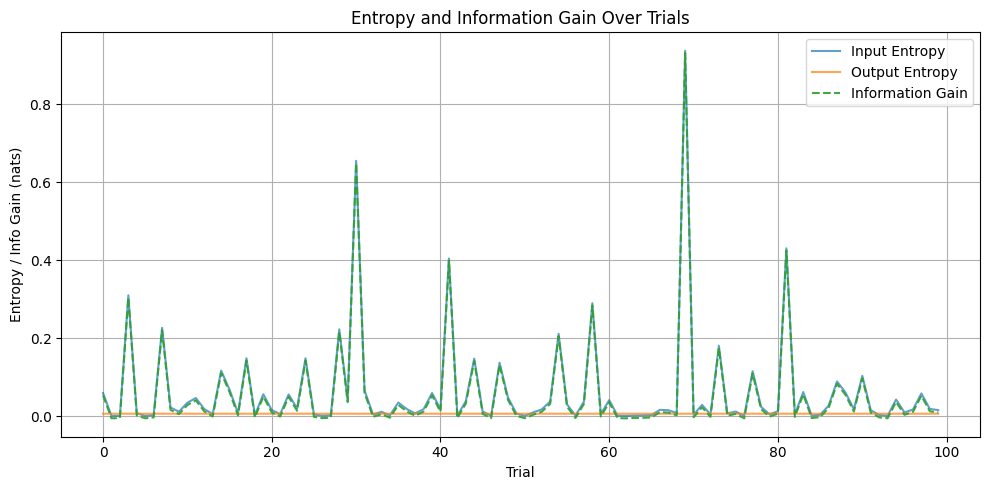

Average input entropy:  0.0637 nats
Average output entropy: 0.0061 nats
Average information gain: 0.0576 nats over 100 runs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode

# Define distance and weights
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def softmax_weights(x, sigma):
    dists = np.array([np.linalg.norm(x - p)**2 for p in patterns])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

# Shannon entropy
def entropy(p):
    p = np.clip(p, 1e-12, 1.0)  # avoid log(0)
    return -np.sum(p * np.log(p))

# ODE system
def memory_dynamics(t, x):
    x = np.array(x)
    w = softmax_weights(x, sigma)
    dxdt = sum(w[i] * (patterns[i] - x) for i in range(len(patterns)))
    return dxdt

# Parameters
patterns = np.array([
    [1.0, 1.0],
    [-1.0, -1.0],
    [1.0, -1.0],
    [-1.0, 1.0]
])
sigma = 0.5
N = 100  # number of runs
dt = 0.05
t_max = 10
perturb_scale = 0.4

entropy_input_list = []
entropy_output_list = []
info_gain_list = []

for _ in range(N):
    true_idx = np.random.randint(len(patterns))
    true_pattern = patterns[true_idx]
    x0 = true_pattern + np.random.normal(scale=perturb_scale, size=true_pattern.shape)

    # Entropy at input
    w_input = softmax_weights(x0, sigma)
    H_input = entropy(w_input)

    # Integrate
    solver = ode(memory_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x0, 0)

    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)

    x_final = solver.y
    w_output = softmax_weights(x_final, sigma)
    H_output = entropy(w_output)

    entropy_input_list.append(H_input)
    entropy_output_list.append(H_output)
    info_gain_list.append(H_input - H_output)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(entropy_input_list, label='Input Entropy', alpha=0.7)
plt.plot(entropy_output_list, label='Output Entropy', alpha=0.7)
plt.plot(info_gain_list, label='Information Gain', alpha=0.9, linestyle='--')
plt.title('Entropy and Information Gain Over Trials')
plt.xlabel('Trial')
plt.ylabel('Entropy / Info Gain (nats)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Average input entropy:  {np.mean(entropy_input_list):.4f} nats")
print(f"Average output entropy: {np.mean(entropy_output_list):.4f} nats")
print(f"Average information gain: {np.mean(info_gain_list):.4f} nats over {N} runs")


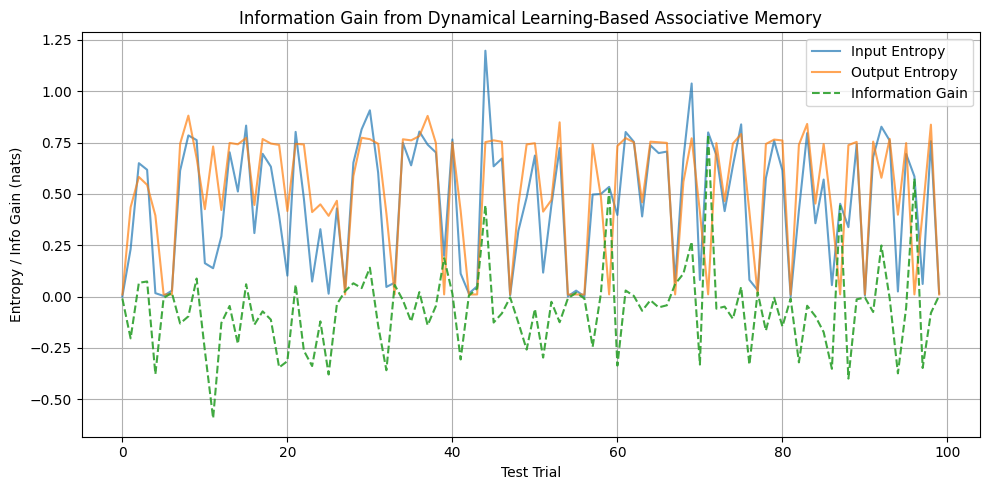

(np.float64(0.45282573378045726),
 np.float64(0.5149097573828465),
 np.float64(-0.062084023602389266))

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

# -------------------------------
# Distance metric and softmax
# -------------------------------
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def softmax_weights(x, centers, sigma):
    dists = np.array([np.linalg.norm(x - p)**2 for p in centers])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

def entropy(p):
    p = np.clip(p, 1e-12, 1.0)  # avoid log(0)
    return -np.sum(p * np.log(p))

# -------------------------------
# Parameters and Data Generation
# -------------------------------
np.random.seed(42)
sigma = 0.5
alpha = 0.05  # learning rate
n_patterns = 4
n_dims = 2
n_train = 100
n_test = 100
perturb_scale = 0.4
t_max = 5
dt = 0.05

# Ground truth training data: cluster centers
true_patterns = np.random.uniform(-1.5, 1.5, (n_patterns, n_dims))

# Generate training data around each pattern
train_data = []
for p in true_patterns:
    samples = p + np.random.normal(scale=0.2, size=(n_train // n_patterns, n_dims))
    train_data.append(samples)
train_data = np.vstack(train_data)

# -------------------------------
# Training: Evolve attractors with ODEs
# -------------------------------
# Initialize learned attractors (can be random or copied from data)
learned_patterns = np.copy(train_data[:n_patterns])  # start with first few data points

def learning_dynamics(t, p_flat, x):
    p = p_flat.reshape((-1, n_dims))
    w = softmax_weights(x, p, sigma)
    dpdt = np.array([alpha * w[i] * (x - p[i]) for i in range(len(p))])
    return dpdt.flatten()

# Train attractors over training data
for x in train_data:
    solver = ode(learning_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(learned_patterns.flatten(), 0)
    solver.set_f_params(x)

    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)

    learned_patterns = solver.y.reshape((-1, n_dims))

# -------------------------------
# Testing: Recall and measure info gain
# -------------------------------
input_entropies = []
output_entropies = []
info_gains = []

for _ in range(n_test):
    idx = np.random.randint(n_patterns)
    original = true_patterns[idx]
    x0 = original + np.random.normal(scale=perturb_scale, size=n_dims)

    # Entropy at input
    w_input = softmax_weights(x0, learned_patterns, sigma)
    H_input = entropy(w_input)

    # Recall dynamics
    def recall_dynamics(t, x):
        w = softmax_weights(x, learned_patterns, sigma)
        dxdt = sum(w[i] * (learned_patterns[i] - x) for i in range(len(learned_patterns)))
        return dxdt

    solver = ode(recall_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x0, 0)

    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)

    x_final = solver.y
    w_output = softmax_weights(x_final, learned_patterns, sigma)
    H_output = entropy(w_output)

    input_entropies.append(H_input)
    output_entropies.append(H_output)
    info_gains.append(H_input - H_output)

# -------------------------------
# Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(input_entropies, label='Input Entropy', alpha=0.7)
plt.plot(output_entropies, label='Output Entropy', alpha=0.7)
plt.plot(info_gains, label='Information Gain', linestyle='--', alpha=0.9)
plt.title("Information Gain from Dynamical Learning-Based Associative Memory")
plt.xlabel("Test Trial")
plt.ylabel("Entropy / Info Gain (nats)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

avg_gain = np.mean(info_gains)
avg_H_input = np.mean(input_entropies)
avg_H_output = np.mean(output_entropies)

avg_H_input, avg_H_output, avg_gain


Loading MNIST...


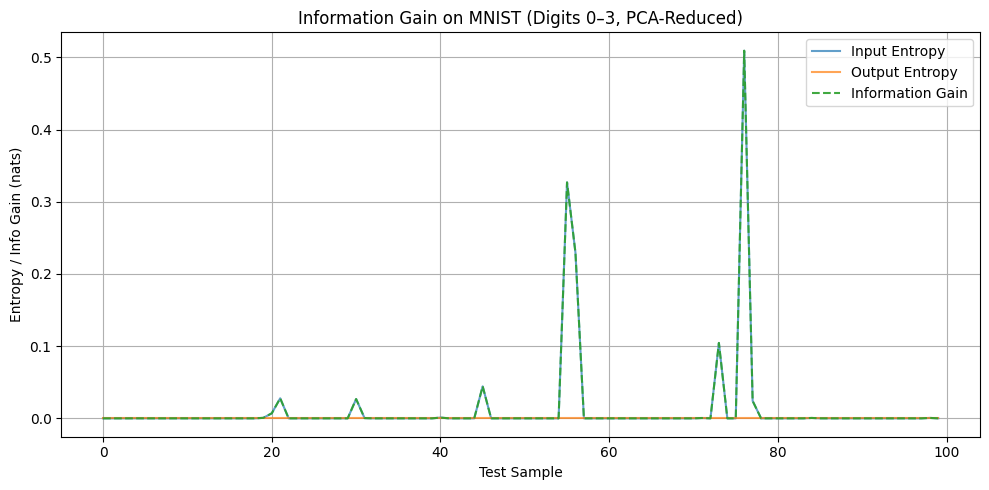

(np.float64(0.013033181326606566),
 np.float64(8.289306334778566e-11),
 np.float64(0.013033181243713504))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# -------------------------------
# Load and preprocess MNIST
# -------------------------------
print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_raw = mnist['data']
y_raw = mnist['target'].astype(int)

# Use only digits 0-3 for simplicity and speed
selected_digits = [0, 1, 2, 3]
mask = np.isin(y_raw, selected_digits)
X = X_raw[mask]
y = y_raw[mask]

# Normalize pixel values to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Optional: reduce dimensionality to speed up ODEs
pca = PCA(n_components=32)  # reduced from 784 to 32 dims
X = pca.fit_transform(X)

# Split into train and test
n_train = 400
n_test = 100
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:n_train + n_test], y[n_train:n_train + n_test]

# -------------------------------
# ODE-based Attractor Learning
# -------------------------------
sigma = 0.5
alpha = 0.05
t_max = 5
dt = 0.05
n_dims = X.shape[1]
n_attractors = len(selected_digits)
attractors = np.copy(X_train[:n_attractors])  # one attractor per class initially

def softmax_weights(x, centers, sigma):
    dists = np.array([np.linalg.norm(x - p)**2 for p in centers])
    exps = np.exp(-0.5 * dists / sigma**2)
    return exps / np.sum(exps)

def learning_dynamics(t, p_flat, x):
    p = p_flat.reshape((-1, n_dims))
    w = softmax_weights(x, p, sigma)
    dpdt = np.array([alpha * w[i] * (x - p[i]) for i in range(len(p))])
    return dpdt.flatten()

for x in X_train:
    solver = ode(learning_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(attractors.flatten(), 0)
    solver.set_f_params(x)
    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)
    attractors = solver.y.reshape((-1, n_dims))

# -------------------------------
# Recall and Information Gain
# -------------------------------
def entropy(p):
    p = np.clip(p, 1e-12, 1.0)
    return -np.sum(p * np.log(p))

input_entropies = []
output_entropies = []
info_gains = []

def recall_dynamics(t, x):
    w = softmax_weights(x, attractors, sigma)
    dxdt = sum(w[i] * (attractors[i] - x) for i in range(len(attractors)))
    return dxdt

for x in X_test:
    # Perturb input
    x0 = x + np.random.normal(scale=0.2, size=n_dims)

    # Input entropy
    w_input = softmax_weights(x0, attractors, sigma)
    H_input = entropy(w_input)

    # Recall
    solver = ode(recall_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x0, 0)
    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)

    x_final = solver.y
    w_output = softmax_weights(x_final, attractors, sigma)
    H_output = entropy(w_output)

    input_entropies.append(H_input)
    output_entropies.append(H_output)
    info_gains.append(H_input - H_output)

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(input_entropies, label='Input Entropy', alpha=0.7)
plt.plot(output_entropies, label='Output Entropy', alpha=0.7)
plt.plot(info_gains, label='Information Gain', linestyle='--', alpha=0.9)
plt.title("Information Gain on MNIST (Digits 0–3, PCA-Reduced)")
plt.xlabel("Test Sample")
plt.ylabel("Entropy / Info Gain (nats)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

np.mean(input_entropies), np.mean(output_entropies), np.mean(info_gains)


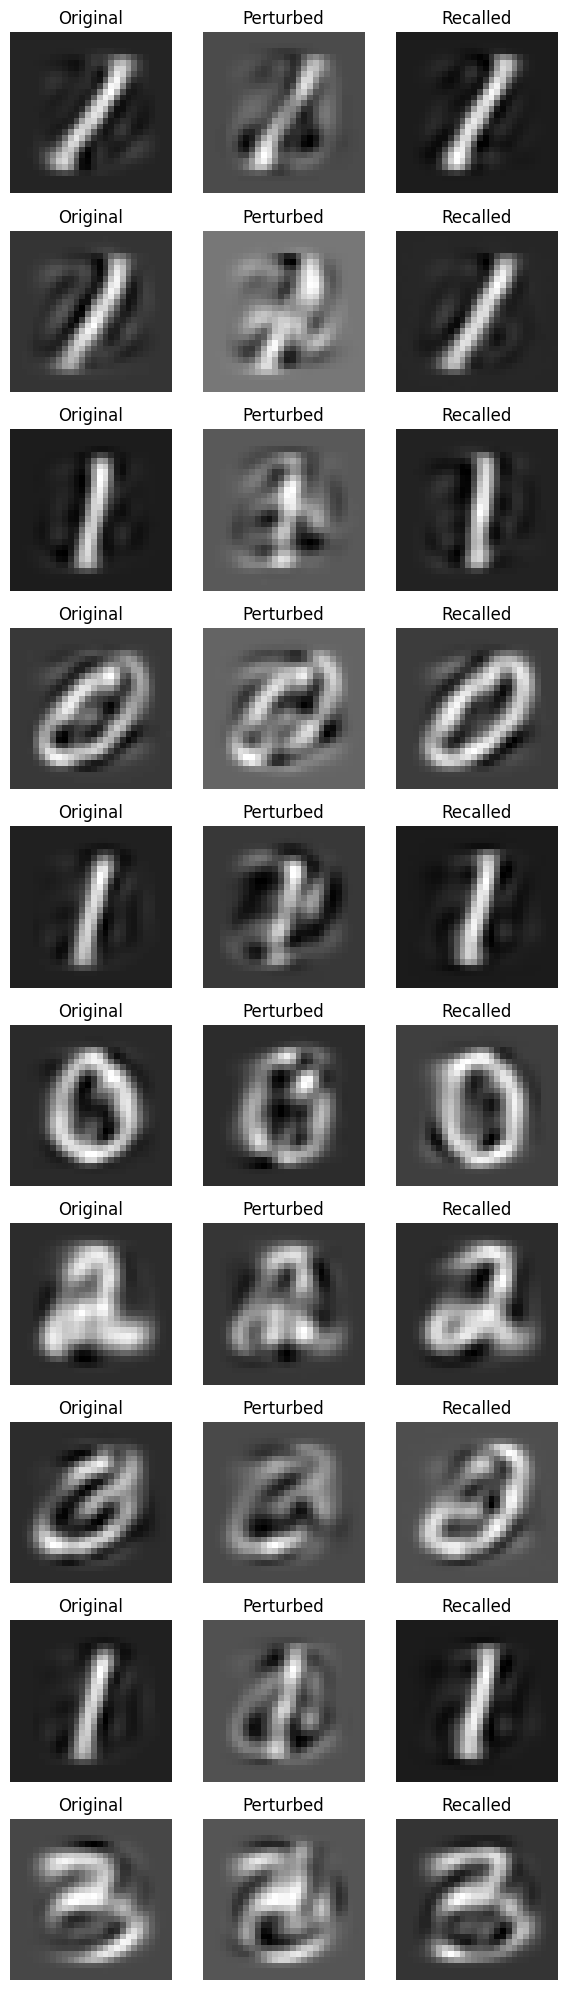

[np.float64(1.0186448836921174), np.float64(1.3862943610369975), np.float64(0.9011898607013191), np.float64(0.4912232254666927)]
['0', '1', '2', '3']


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import mnist
from scipy.integrate import ode

# --- Parameters ---
n_dims = 32         # PCA dimensions
n_train = 400       # number of training patterns
n_test = 100        # test samples to try
sigma = 0.1         # soft attention scale
noise_std = 1.0     # perturbation noise
t_max = 5.0         # ODE max time
dt = 0.1            # ODE step size
selected_digits = [0, 1, 2, 3]

# --- Load MNIST using Keras ---
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()
X_train_raw = X_train_raw.reshape(-1, 784) / 255.0
X_test_raw = X_test_raw.reshape(-1, 784) / 255.0

# Filter digits 0–3
train_mask = np.isin(y_train_raw, selected_digits)
test_mask = np.isin(y_test_raw, selected_digits)

X = np.concatenate([X_train_raw[train_mask], X_test_raw[test_mask]])
y = np.concatenate([y_train_raw[train_mask], y_test_raw[test_mask]])

# Normalize and PCA
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=n_dims)
X_pca = pca.fit_transform(X_scaled)

X_train = X_pca[:n_train]
X_test = X_pca[n_train:n_train + n_test]

# Use training points as attractors
attractors = X_train.copy()

# --- Softmax-based ODE field ---
def softmax_weights(x, patterns, sigma):
    dists = np.linalg.norm(patterns - x, axis=1)
    logits = -dists**2 / (2 * sigma**2)
    weights = np.exp(logits - np.max(logits))
    return weights / np.sum(weights)

def recall_dynamics(t, x):
    w = softmax_weights(x, attractors, sigma)
    dxdt = np.sum(w[:, None] * (attractors - x), axis=0)
    return dxdt

# --- Inverse transform for image reconstruction ---
def inverse_pca(x):
    return pca.inverse_transform(x).reshape(28, 28)

# --- Run recall on N test samples and visualize ---
n_display = 10
fig, axes = plt.subplots(nrows=n_display, ncols=3, figsize=(6, n_display * 2))

for i in range(n_display):
    idx = np.random.randint(len(X_test))
    x_true = X_test[idx]
    x_noisy = x_true + np.random.normal(scale=noise_std, size=x_true.shape)

    solver = ode(recall_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x_noisy, 0)
    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)
    x_recalled = solver.y

    # Plot original, perturbed, and recalled
    axes[i, 0].imshow(inverse_pca(x_true), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(inverse_pca(x_noisy), cmap='gray')
    axes[i, 1].set_title("Perturbed")
    axes[i, 2].imshow(inverse_pca(x_recalled), cmap='gray')
    axes[i, 2].set_title("Recalled")

    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


import seaborn as sns

from collections import defaultdict
class_stats = defaultdict(lambda: {'inputs': [], 'outputs': []})

# Collect statistics
for i in range(n_test):
    x_true = X_test[i]
    y_true = y[n_train + i]  # because test labels are after training set
    x_noisy = x_true + np.random.normal(scale=noise_std, size=x_true.shape)

    # Run dynamics
    solver = ode(recall_dynamics)
    solver.set_integrator('dopri5')
    solver.set_initial_value(x_noisy, 0)
    while solver.successful() and solver.t < t_max:
        solver.integrate(solver.t + dt)
    x_recalled = solver.y

    # Find nearest attractor
    dists = np.linalg.norm(attractors - x_recalled, axis=1)
    nearest_idx = np.argmin(dists)
    recalled_label = y_train_raw[train_mask][nearest_idx]

    class_stats[y_true]['inputs'].append(x_noisy)
    class_stats[y_true]['outputs'].append(recalled_label)

# --- Compute Info Gain ---
digit_gains = []
digit_labels = []

for digit in selected_digits:
    outputs = class_stats[digit]['outputs']
    if len(outputs) == 0:
        continue

    # Prior entropy (uniform over all selected digits)
    prior_p = np.ones(len(selected_digits)) / len(selected_digits)
    H_input = entropy(prior_p)

    # Output distribution
    counts = np.array([outputs.count(d) for d in selected_digits])
    probs = counts / np.sum(counts)
    H_output = entropy(probs)

    gain = H_input - H_output
    digit_gains.append(gain)
    digit_labels.append(str(digit))

print(digit_gains)
print(digit_labels)
